In [ ]:
import keras
import tensorflow as tf
from google.colab import drive
from google.colab import files
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
drive.mount('/content/drive/')

ruta="/content/drive/My Drive/DataSets/Granos_Polen"



Mounted at /content/drive/


In [ ]:
#Filtros para imagenes
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def Neighborhood_Operation(img):
  h, w, c = img.shape
  crop_img = img[0:h, 0:w]

def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1)*pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

def Contrast_Stretching(img):
  r1 = 66
  s1 = 0
  r2 = 152
  s2 = 255

  pixelVal_vec = np.vectorize(pixelVal)

  contrast_stretched = pixelVal_vec(img, r1, s1, r2, s2)

  cv2_imshow(contrast_stretched)


def Grey_level_slicing(img, T1=100, T2=180):

  h,w = img.shape

  img_thresh_back = np.zeros((h,w), dtype = int)

  for i in range(h):
      for j in range(w):
          if (T1 < img[i,j]).any() and (img[i,j] < T2).any():
              img_thresh_back[i,j]= 255
          else:
              img_thresh_back[i-1,j-1] = img[i-1,j-1]
  return img_thresh_back


def modificar_gamma(img, tipo, gamma=0.5):

  gamma=gamma
  if tipo==1:
    gamma=0.5
  elif tipo==2:
    gamma=1.5
  elif tipo==3:
    gamma=2.
  elif tipo==4:
    gamma=2.5

  gamma_corrected_img = np.array(255*(img / 255) ** gamma, dtype = 'uint8')
  return(gamma_corrected_img)

def masking(img, tipo):
  if tipo==1:
    #Detección de ejes
    kernel = np.array([
            [-1, -1, -1],
            [-1, 8, -1],
            [-1, -1, -1]
          ])
  elif tipo==2:
    #Nitidez de la imagen
    kernel = np.array([
          [0, -1, 0],
          [-1, 5, -1],
          [0, -1, 0]
        ])
  elif tipo==3:
    #"box filtering, suavizado"
    kernel = np.array([
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]
            ]) / 9
  elif tipo==4:
    L = img.max()
    imgNeg = L-img
    cv2_imshow(imgNeg)
    return img
  elif tipo==5:
    kernel = np.array([[-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, 0]])
    kernel = 1/3 * kernel
  elif tipo==6:
    kernel = np.array([[-1, -1, -1],
                      [-1, 8, -1],
                      [-1, -1, 0]])
    kernel = 1/3 * kernel
    img=cv2.filter2D(img, -1, kernel)
    img=modificar_gamma(img,2)
    return img
  else:
    return img

  return cv2.filter2D(img, -1, kernel)

def extract_bit_plane(cd):
    #  extracting all bit one by one
    # from 1st to 8th in variable
    # from c1 to c8 respectively
    c1 = np.mod(cd, 2)
    c2 = np.mod(np.floor(cd/2), 2)
    c3 = np.mod(np.floor(cd/4), 2)
    c4 = np.mod(np.floor(cd/8), 2)
    c5 = np.mod(np.floor(cd/16), 2)
    c6 = np.mod(np.floor(cd/32), 2)
    c7 = np.mod(np.floor(cd/64), 2)
    c8 = np.mod(np.floor(cd/128), 2)
    # combining image again to form equivalent to original grayscale image
    cc = 2 * (2 * (2 * c8 + c7) + c6) # reconstructing image  with 3 most significant bit planes
    img=cc
    to_plot = [cd, c1, c2, c3, c4, c5, c6, c7, c8, cc]
    fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for ax, i in zip(axes.flat, to_plot):
        ax.imshow(i, cmap='gray')
    return img


def filtro(img, tratamiento):
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


  if tratamiento==0:
    img=img-img.max()
  elif tratamiento==1:
    img=img-img.min()
    img=extract_bit_plane(img)
  elif tratamiento==2:
    img=img-img.min()
    img=masking(img,1)
  elif tratamiento==3:
    img=img-img.min()
    img=masking(img,2)
  elif tratamiento==4:
    img=img-img.min()
    img=masking(img,3)
  elif tratamiento==5:
    img=masking(img,4)
  elif tratamiento==6:
    img=modificar_gamma(img,1)
  elif tratamiento==7:
    img=modificar_gamma(img,2)
  elif tratamiento==8:
    img=modificar_gamma(img,3)
  elif tratamiento==9:
    img=modificar_gamma(img,4)
  elif tratamiento==10:
    img=img-img.min()
    img=Grey_level_slicing(img,10,100)
  elif tratamiento==11:
    img=img-img.min()
    img=255-img
  elif tratamiento==12:
    img=img-img.min()
    img=masking(img,5)
  elif tratamiento==13:
    img=img-img.min()
    img=masking(img,6)

  return img

In [ ]:
#Realizamos o no filtros a las imágenes
import matplotlib.pyplot as plt
import os
import glob

entrenoFiltro=ruta+"/trainFiltro"
testeoFiltro=ruta+"/testFiltro"
valFiltro=ruta+"/valFiltro"

entreno=ruta+"/train"
testeo=ruta+"/test"
val=ruta+"/val"

EnrKunzea=os.listdir(entreno+"/Tipo_A_Kunzea")
TesKunzea=os.listdir(testeo+"/Tipo_A_Kunzea")
ValKunzea=os.listdir(val+"/Tipo_A_Kunzea")

EnrLepto=os.listdir(entreno+"/Tipo_B_Lepto")
TesLetpo=os.listdir(testeo+"/Tipo_B_Lepto")
ValLepto=os.listdir(val+"/Tipo_B_Lepto")

files = glob.glob(entrenoFiltro+"/Tipo_A_Kunzea/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(entrenoFiltro+"/Tipo_B_Lepto/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(testeoFiltro+"/Tipo_A_Kunzea/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(testeoFiltro+"/Tipo_B_Lepto/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(valFiltro+"/Tipo_A_Kunzea/"+"/*")
for f in files:
    os.remove(f)

files = glob.glob(valFiltro+"/Tipo_B_Lepto/"+"/*")
for f in files:
    os.remove(f)


n_tratamiento=3

for i in range(len(EnrKunzea)):
  img=cv2.imread(entreno+"/Tipo_A_Kunzea/"+EnrKunzea[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(entrenoFiltro+"/Tipo_A_Kunzea/"+EnrKunzea[i], img, cmap='gray')

for i in range(len(EnrLepto)):
  img=cv2.imread(entreno+"/Tipo_B_Lepto/"+EnrLepto[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(entrenoFiltro+"/Tipo_B_Lepto/"+EnrLepto[i], img, cmap='gray')

for i in range(len(TesKunzea)):
  img=cv2.imread(testeo+"/Tipo_A_Kunzea/"+TesKunzea[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(testeoFiltro+"/Tipo_A_Kunzea/"+TesKunzea[i], img, cmap='gray')

for i in range(len(TesLetpo)):
  img=cv2.imread(testeo+"/Tipo_B_Lepto/"+TesLetpo[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(testeoFiltro+"/Tipo_B_Lepto/"+TesLetpo[i], img, cmap='gray')

for i in range(len(ValKunzea)):
  img=cv2.imread(val+"/Tipo_A_Kunzea/"+ValKunzea[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(valFiltro+"/Tipo_A_Kunzea/"+ValKunzea[i], img, cmap='gray')

for i in range(len(ValLepto)):
  img=cv2.imread(val+"/Tipo_B_Lepto/"+ValLepto[i])
  img=filtro(img,n_tratamiento)
  plt.imsave(valFiltro+"/Tipo_B_Lepto/"+ValLepto[i], img, cmap='gray')


In [ ]:
input_shape = (100,100,3)

modelo_P = keras.Sequential([
    keras.layers.Flatten(input_shape=(input_shape)),
    keras.layers.Dense(1, activation='sigmoid')
])

modelo_P.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 1)                 30001     
                                                                 
Total params: 30,001
Trainable params: 30,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo_P.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


entreno=ruta+"/train"
testeo=ruta+"/test"
val=ruta+"/val"


datagen = ImageDataGenerator(
    rescale=1./255)
datagen.flow


train_it = datagen.flow_from_directory(entreno, batch_size=64, target_size=(100, 100),class_mode='binary')
test_it = datagen.flow_from_directory(testeo, batch_size=64, target_size=(100, 100),class_mode='binary')
validation_it = datagen.flow_from_directory(val, batch_size=64, target_size=(100, 100),class_mode='binary')


Found 1920 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [ ]:
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-4, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4)

epocas = 50

ajuste = modelo_P.fit(
      train_it,
      steps_per_epoch=len(train_it),
      validation_data=validation_it,
      validation_steps=len(validation_it),
      epochs=epocas,
      verbose=1,
      callbacks=[es, rlrop])

Epoch 1/50
30/30 [==============================] - 441s 15s/step - loss: 0.4276 - accuracy: 0.8005 - val_loss: 0.3551 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 4s 141ms/step - loss: 0.3232 - accuracy: 0.8698 - val_loss: 0.3389 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 4s 134ms/step - loss: 0.3090 - accuracy: 0.8740 - val_loss: 0.3326 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 5s 151ms/step - loss: 0.2968 - accuracy: 0.8760 - val_loss: 0.3358 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 4s 138ms/step - loss: 0.2830 - accuracy: 0.8859 - val_loss: 0.3703 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 4s 146ms/step - loss: 0.2808 - accuracy: 0.8844 - val_loss: 0.3482 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 7/50
30/30 [==============================] - 4s 144ms/step - lo

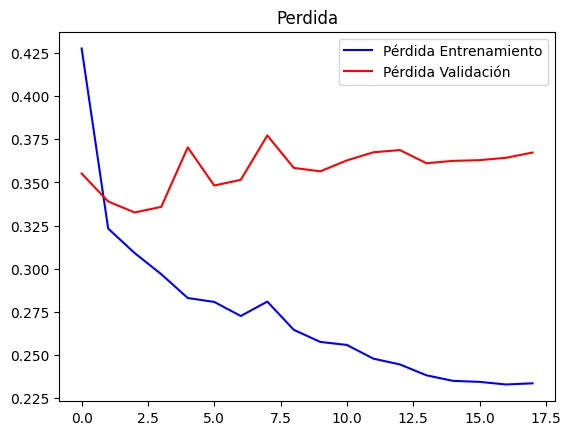

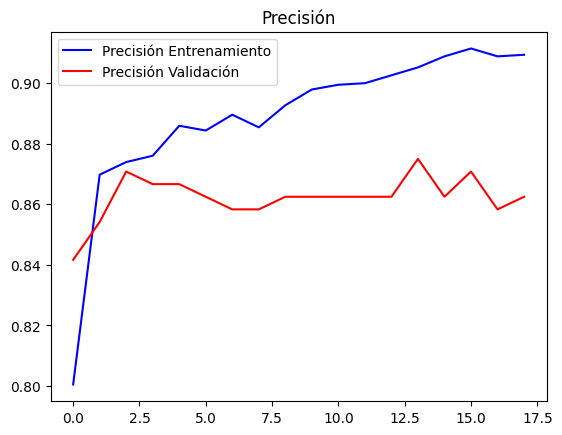

In [ ]:
from matplotlib import pyplot
def seguimiento(ajuste):

  pyplot.figure(0)
  pyplot.title('Perdida')
  pyplot.plot(ajuste.history['loss'], color='blue', label='train')
  pyplot.plot(ajuste.history['val_loss'], color='red', label='test')
  pyplot.legend(['Pérdida Entrenamiento','Pérdida Validación'])


  pyplot.figure(1)
  pyplot.title('Precisión')
  pyplot.plot(ajuste.history['accuracy'], color='blue', label='train')
  pyplot.plot(ajuste.history['val_accuracy'], color='red', label='test')
  pyplot.legend(['Precisión Entrenamiento','Precisión Validación'])


seguimiento(ajuste)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools


def plot_confusion_matrix(cm, model_name, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.savefig('/content/confusionmatrix-'+ model_name +'.png')
    pyplot.show()

def validateResults(model, model_name):
  validation_images = []  # Lista para almacenar las imágenes
  validation_labels = []  # Lista para almacenar las etiquetas

  i=0
  for batch_images, batch_labels in validation_it:
      validation_images.extend(batch_images)
      batch_label_indices = np.argmax(batch_labels, axis=1)
      validation_labels.extend(batch_label_indices)

      if len(validation_images) >= len(validation_it.filenames):
          break

  validation_images = np.array(validation_images)
  validation_labels = np.array(validation_labels)


  predictions = model.predict(validation_images, batch_size=32)

  pred=[]
  for i in predictions:
    indice=list(i).index(max(i))
    pred.append(indice)

  y_val=[int(i) for i in validation_labels]
  y_pred=pred

  clases=["Kunzea","Lepto"]
  print("\n"+ classification_report(y_val, y_pred, target_names=clases))
  confusion_mtx = confusion_matrix(y_val, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, model_name, classes = list(clases), normalize=False)

validateResults(modelo_P, 'model1')

AxisError: ignored